In [1]:
# Setup autoreload and add parent dir to sys.path
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')

In [6]:
from datasets import load_kung_sa_dataset
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['font.size'] = 18

In [7]:
(X_train, y_train), (X_test, y_test) = load_kung_sa_dataset(
                        private_features=False,
                        private_targets=True,
                        eps=2.0,
                        delta=0, #1/230,
                        mechanism='lap')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Adding independent Laplace noise with scale=65.0000


((229, 1), (229, 1), (58, 1), (58, 1))

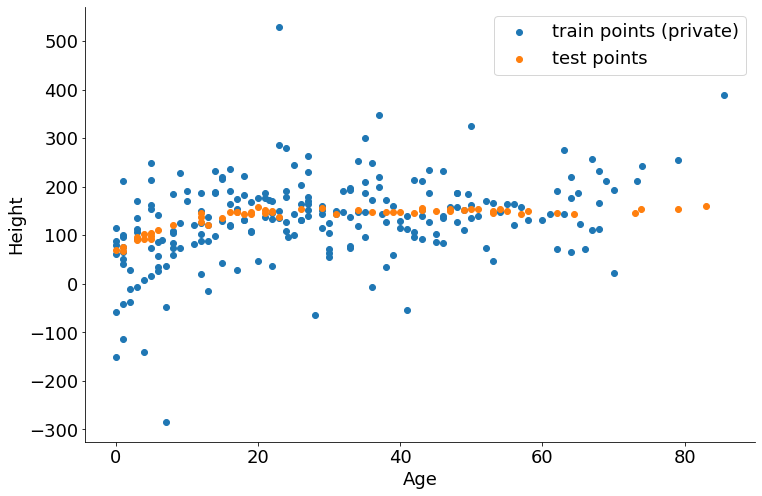

In [8]:
plt.scatter(X_train, y_train, label='train points (private)')
plt.scatter(X_test, y_test, label='test points')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Height")
sns.despine()

In [9]:
gpr_model = gpflow.models.GPR((X_train, y_train), kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]))
gpr_model.likelihood.variance.assign(270.0)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr_model.training_loss, gpr_model.trainable_variables, options=dict(maxiter=100))
print(opt_logs)
mu_pred, var_pred = gpr_model.predict_y(X_test)

2022-07-13 12:40:37.553360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 12:40:37.553448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-13 12:40:37.553496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-13 12:40:37.555769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-07-13 12:40:37.555827: W tensorflow/stream_executor/platform/default/dso_loader

      fun: 1345.0823186375014
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.11420007, -0.00491037, -0.00775778])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 18
     njev: 24
   status: 0
  success: True
        x: array([  25.55731117, 2160.04918696, 4686.41911295])


In [10]:
## predict mean and variance of latent GP at test points
mean, var = gpr_model.predict_f(X_test)

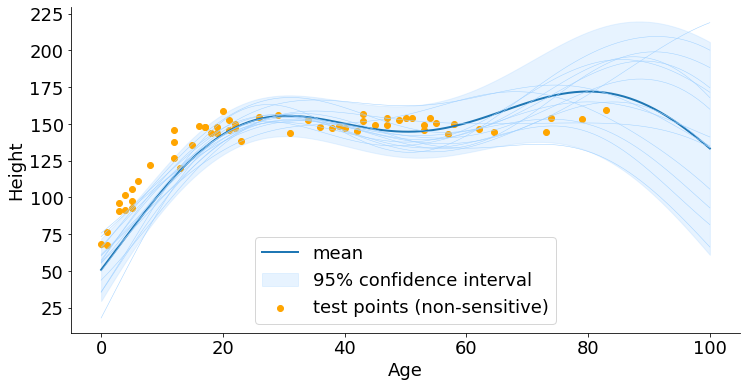

log marginal likelihood (observations): -1345.082
test-set mse: 201.265


In [11]:
## generate test points for prediction
xx = np.linspace(0, 100, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = gpr_model.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = gpr_model.predict_f_samples(xx, 15)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(xx, mean, c="C0", lw=2, label="mean")
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="#A2D2FF",
    alpha=0.25,
    label="95% confidence interval"
)
plt.plot(xx, samples[:, :, 0].numpy().T, c="#A2D2FF", linewidth=0.5, alpha=1.)
plt.scatter(X_test, y_test, label='test points (non-sensitive)', color="orange")
sns.despine()
plt.legend()
plt.xlabel("Age")
plt.ylabel("Height")
#plt.savefig("figures/gpr_fit_kung_sa.svg")
plt.show()

# print metrics
mu, var = gpr_model.predict_f(X_test)
mse = tf.keras.metrics.mean_squared_error
print(f"log marginal likelihood (observations): {gpr_model.log_marginal_likelihood().numpy():.3f}")
print(f"test-set mse: {mse(tf.squeeze(mu), tf.squeeze(y_test)).numpy():.3f}")

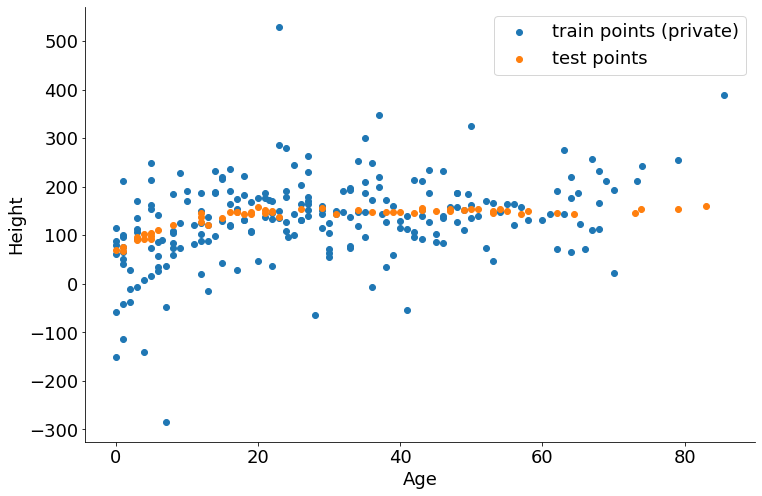

In [12]:
plt.scatter(X_train, y_train, label='train points (private)')
plt.scatter(X_test, y_test, label='test points')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Height")
sns.despine()

In [13]:
from gpflow.utilities import print_summary
print_summary(gpr_model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2160.0491869614248
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[25.55731117]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4686.419113945036
